<a href="https://colab.research.google.com/github/newgabo/TP2-AA/blob/master/TP2_AA_Modelos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Si van a realizar el TP con canto Mongol, que sea bien arriba!

https://open.spotify.com/track/4JvM2JzkfRjMYy9pexVeRV?si=6N0bTnkHQOGm-GRvMv7n1A

Import's

In [2]:
from io import BytesIO

import os
import sys
import pickle
import math
import random
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import librosa
import glob

import scipy.io.wavfile

from shutil import copyfile

from IPython.display import Audio

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV


# Notación Científica a Decimal
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Features

In [3]:
# Desde nuestro repo!
github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_numbers.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features = pickle.load(file_)

df_features.shape

(23666, 81)

In [4]:
df_features.head(3)

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
0,-447.013,82.107,30.129,37.495,26.410,19.350,0.221,13.787,-2.091,10.187,-7.550,10.406,0.020,105.243,66.167,31.379,17.045,16.423,8.988,9.500,9.900,9.094,6.358,9.571,5.839,0.020,2.496,2.679,1.383,0.637,0.353,-0.075,-0.396,0.066,0.210,0.001,-0.285,-0.135,0.000,30.678,...,16.547,10.995,9.366,8.321,6.260,6.316,6.087,5.225,6.299,4.700,0.005,-0.892,-0.599,-0.008,0.031,0.060,0.012,-0.036,-0.154,0.044,0.055,-0.319,-0.205,0.000,27.638,17.219,17.457,12.668,12.201,9.885,6.972,6.423,8.006,6.841,7.951,6.087,0.004,zero,zero/b087aa0e_nohash_3.wav,train
1,-467.465,106.486,-15.164,-15.917,-14.514,-0.944,-22.115,-2.099,-15.078,-5.340,-2.508,-4.010,0.014,143.691,70.236,41.396,40.315,12.078,11.623,22.693,9.660,21.297,13.317,17.372,9.551,0.016,-7.602,0.237,0.089,-2.493,-0.741,-1.250,-0.836,-0.696,0.170,0.122,0.354,-0.369,-0.000,39.752,...,20.763,13.505,7.302,7.357,9.344,5.286,8.008,7.524,8.351,6.591,0.004,1.047,0.668,0.701,0.556,0.056,0.025,-0.053,0.377,0.467,-0.151,-0.275,-0.094,0.000,26.817,19.741,18.224,13.531,8.567,8.785,10.018,5.970,7.915,9.536,8.486,7.919,0.002,zero,zero/1a892463_nohash_1.wav,train
2,-387.342,103.399,19.127,14.151,4.236,2.917,-8.341,-4.872,0.061,-0.831,-3.717,2.288,0.012,64.781,35.180,33.912,21.784,12.908,6.430,16.484,13.219,10.295,8.538,6.550,5.132,0.008,-0.206,0.652,-0.220,0.448,-0.305,-0.063,-0.035,-0.006,-0.274,-0.224,-0.302,-0.081,-0.000,22.896,...,13.690,14.482,9.327,5.372,8.143,6.306,7.962,4.619,3.983,4.335,0.002,-0.037,-0.071,0.117,-0.118,-0.021,0.003,-0.007,0.066,0.037,0.016,-0.083,-0.235,0.000,21.680,12.490,10.517,13.018,10.620,6.833,9.695,7.443,8.834,4.592,4.575,5.141,0.002,zero,zero/fb2f3242_nohash_0.wav,train


In [5]:
# Algunos controles para yo entender la data nuevamente
df_features.groupby('target').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,group
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eight,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352
five,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357
four,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372
nine,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364
one,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370
seven,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377
six,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369
three,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,235

In [6]:
df_features.groupby('group').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
testing,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552
train,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620
validation,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494


# Modelos

Definimos los conjutnos de train  y validation

In [7]:
df_train = df_features[df_features['group'] == 'train']

del df_train['group']
del df_train['file']
len(df_train.index)

18620

In [8]:
features = df_train.loc[:, df_train.columns != 'target'].columns
target = 'target'

x_train, y_train = df_train[features].values, df_train[target].values

In [9]:
# Validation Set
df_validation = df_features[df_features['group'] == 'validation']

del df_validation['group']
del df_validation['file']
len(df_validation.index)

2494

In [10]:
x_validation, y_validation = df_validation[features].values, df_validation[target].values

In [11]:
features

Index(['mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean',
       'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean',
       'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean',
       'energy_mean', 'mfcc_0_std', 'mfcc_1_std', 'mfcc_2_std', 'mfcc_3_std',
       'mfcc_4_std', 'mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std', 'mfcc_8_std',
       'mfcc_9_std', 'mfcc_10_std', 'mfcc_11_std', 'energy_std',
       'dmfcc_0_mean', 'dmfcc_1_mean', 'dmfcc_2_mean', 'dmfcc_3_mean',
       'dmfcc_4_mean', 'dmfcc_5_mean', 'dmfcc_6_mean', 'dmfcc_7_mean',
       'dmfcc_8_mean', 'dmfcc_9_mean', 'dmfcc_10_mean', 'dmfcc_11_mean',
       'denergy_mean', 'dmfcc_0_std', 'dmfcc_1_std', 'dmfcc_2_std',
       'dmfcc_3_std', 'dmfcc_4_std', 'dmfcc_5_std', 'dmfcc_6_std',
       'dmfcc_7_std', 'dmfcc_8_std', 'dmfcc_9_std', 'dmfcc_10_std',
       'dmfcc_11_std', 'denergy_std', 'ddmfcc_0_mean', 'ddmfcc_1_mean',
       'ddmfcc_2_mean', 'ddmfcc_3_mean', 'ddmfcc_4_mean', 'ddmfcc_5_mean',
       'ddmf

### Naive Bayes

In [12]:
clf_nb_ = GaussianNB()
clf_nb_.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

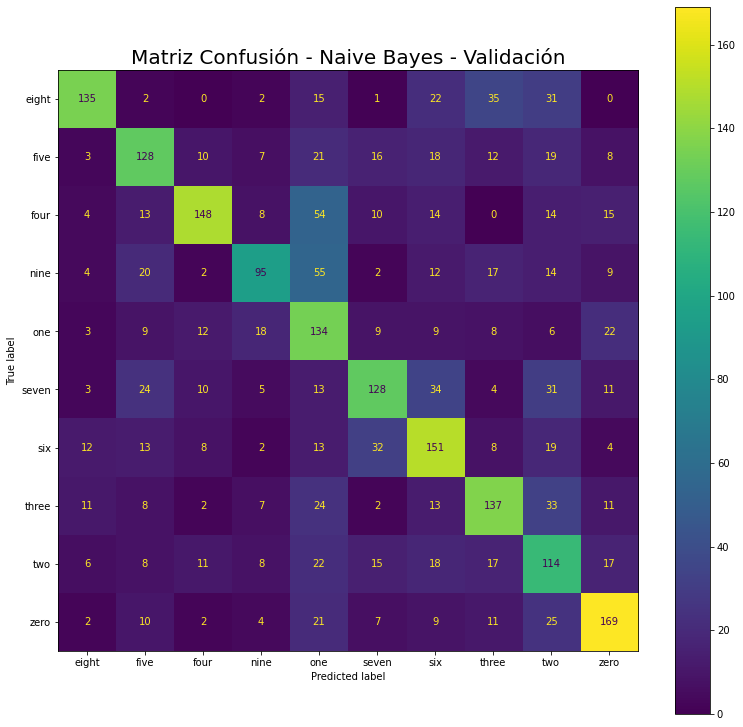

Accuracy Training : 0.541
Accuracy Validation: 0.537


In [13]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_confusion_matrix(clf_nb_, x_validation, y_validation, ax = ax,values_format='.0f')
plt.title("Matriz Confusión - Naive Bayes - Validación", size=20)
plt.show()

print("Accuracy Training : {:.3f}".format(clf_nb_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_nb_.score(x_validation, y_validation)))

In [14]:
# medidas de performance 
y_validation_pred= clf_nb_.predict(x_validation)
clf_nb_score=pd.DataFrame.from_dict(classification_report(y_validation,y_validation_pred,output_dict=True))

print(classification_report(y_validation,y_validation_pred))

              precision    recall  f1-score   support

       eight       0.74      0.56      0.63       243
        five       0.54      0.53      0.54       242
        four       0.72      0.53      0.61       280
        nine       0.61      0.41      0.49       230
         one       0.36      0.58      0.45       230
       seven       0.58      0.49      0.53       263
         six       0.50      0.58      0.54       262
       three       0.55      0.55      0.55       248
         two       0.37      0.48      0.42       236
        zero       0.64      0.65      0.64       260

    accuracy                           0.54      2494
   macro avg       0.56      0.54      0.54      2494
weighted avg       0.57      0.54      0.54      2494



### Bagging Parameters


*   n_estimators
*   max_features
*   oob_score

### Tree-specific Parameters


*   max_depth
*   min_samples_split
*   min_samples_leaf
*   class_weight (balanced)



### Random Forest

In [15]:
parameters = {'n_estimators':[50,100,150], 
              'criterion' :['gini', 'entropy'],
              'max_depth':range(5,11,1), 
              'bootstrap':[True, False], 
              'max_features': [6, 8, 10]}

clf_rf_ = RandomizedSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, n_iter=15, scoring='accuracy',verbose=2, cv=None)
clf_rf_.fit(x_train, y_train)
clf_rf_be_ = clf_rf_.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 26.5min finished


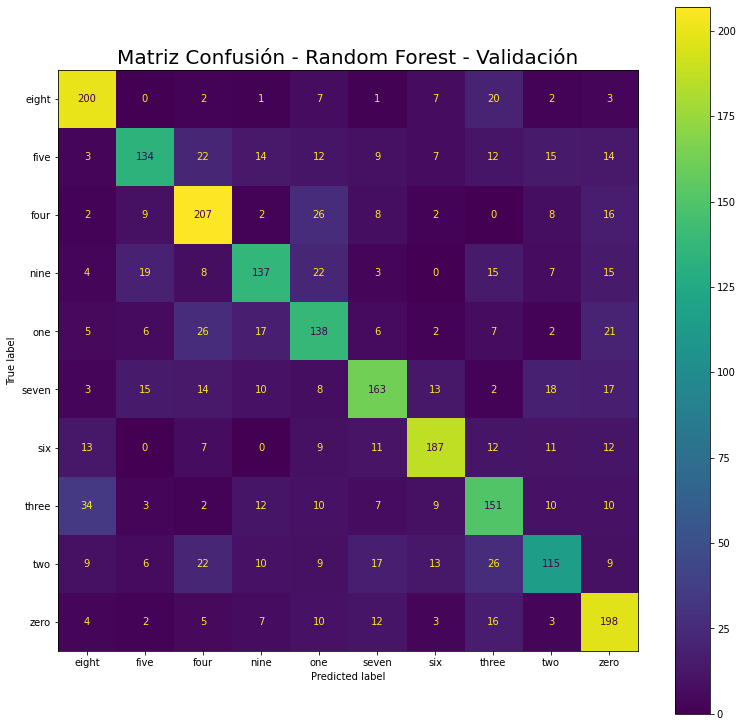

Accuracy training : 0.831
Accuracy Validation: 0.654
Best Random Forest Score 0.665 with params {'n_estimators': 150, 'max_features': 8, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': False}


In [16]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_confusion_matrix(clf_rf_be_, x_validation, y_validation, ax = ax,values_format='.0f')
plt.title("Matriz Confusión - Random Forest - Validación", size=20)
plt.show()


print("Accuracy training : {:.3f}".format(clf_rf_be_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_rf_be_.score(x_validation, y_validation)))
print("Best Random Forest Score {0:.3f} with params {1}".format(clf_rf_.best_score_, clf_rf_.best_params_))

In [17]:
# medidas de performance 
y_validation_pred= clf_rf_.predict(x_validation)

print(classification_report(y_validation,y_validation_pred))

clf_rf_score=pd.DataFrame.from_dict(classification_report(y_validation,y_validation_pred,output_dict=True))


              precision    recall  f1-score   support

       eight       0.72      0.82      0.77       243
        five       0.69      0.55      0.61       242
        four       0.66      0.74      0.70       280
        nine       0.65      0.60      0.62       230
         one       0.55      0.60      0.57       230
       seven       0.69      0.62      0.65       263
         six       0.77      0.71      0.74       262
       three       0.58      0.61      0.59       248
         two       0.60      0.49      0.54       236
        zero       0.63      0.76      0.69       260

    accuracy                           0.65      2494
   macro avg       0.65      0.65      0.65      2494
weighted avg       0.66      0.65      0.65      2494



### Gradient Boosting 

1.   Initial Model (weak estimator)
2.   New Model fits to residuals
3.   New additive model
4.   Repeat n times or until error is small enough
5.   Final additive model

A diferencia de los modelos por Votación, en Gradient Boosting los estimadores no se combinan mediante votación o promedios, sino por suma. Se debe a que el primer modelo se ajusta a la variable objetivo y el resto son estimaciones de los errores residuales.

Parámetros:
*   n_estimators
*   learning_rate
*   max_depth
*   min_samples_split
*   min_samples_leaf
*   max_features

En Gradient Boosting se recomiendan utilizar todos los parámetros.

In [20]:
parameters = {
    "learning_rate": np.linspace(0,0.1, num=10),
    "max_depth": range(3,9,1),
    'max_features': [6, 8, 10],
    "n_estimators": [10]
    }          


clf_gb_ = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_jobs=-1, scoring='accuracy',verbose=2,cv=None)
clf_gb_.fit(x_train, y_train)

clf_gb_be_ = clf_gb_.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.9min finished


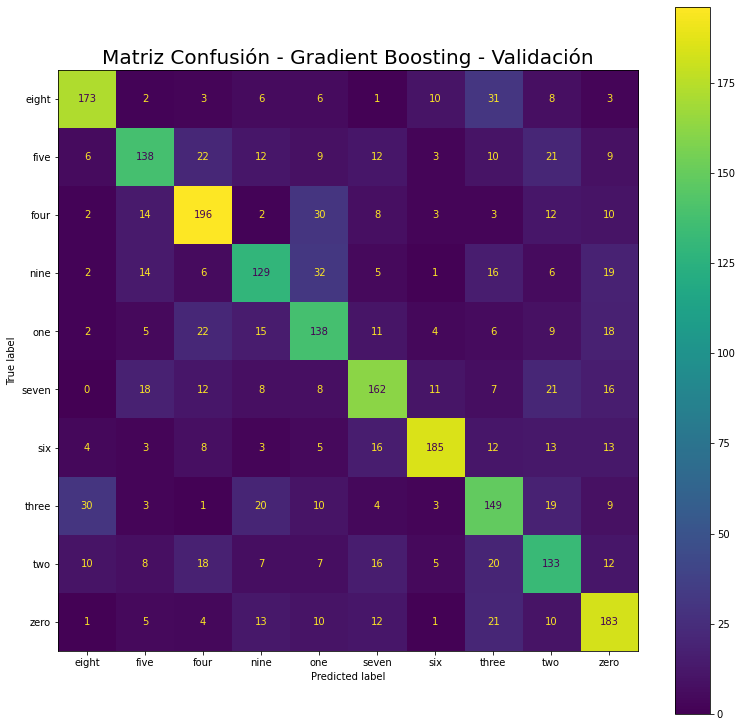

Accuracy training : 0.898
Accuracy Validation: 0.636
Best Gradient Boosting Score 0.646 with params {'n_estimators': 10, 'max_features': 10, 'max_depth': 8, 'learning_rate': 0.044444444444444446}


In [24]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_confusion_matrix(clf_gb_, x_validation, y_validation, ax = ax,values_format='.0f')
plt.title("Matriz Confusión - Gradient Boosting - Validación", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_gb_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_gb_.score(x_validation, y_validation)))
print("Best Gradient Boosting Score {0:.3f} with params {1}".format(clf_gb_.best_score_, clf_gb_.best_params_))

In [25]:
# medidas de performance 
from sklearn.metrics import classification_report
y_validation_pred= clf_gb_.predict(x_validation)

print(classification_report(y_validation,y_validation_pred))
clf_gb_score=pd.DataFrame.from_dict(classification_report(y_validation,y_validation_pred,output_dict=True))

              precision    recall  f1-score   support

       eight       0.75      0.71      0.73       243
        five       0.66      0.57      0.61       242
        four       0.67      0.70      0.69       280
        nine       0.60      0.56      0.58       230
         one       0.54      0.60      0.57       230
       seven       0.66      0.62      0.64       263
         six       0.82      0.71      0.76       262
       three       0.54      0.60      0.57       248
         two       0.53      0.56      0.55       236
        zero       0.63      0.70      0.66       260

    accuracy                           0.64      2494
   macro avg       0.64      0.63      0.63      2494
weighted avg       0.64      0.64      0.64      2494



### Multilayer Perceptron

In [23]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

clf_mlp_ = RandomizedSearchCV(MLPClassifier(max_iter=100), parameter_space, n_jobs=-1, scoring='accuracy', verbose=2, cv=None)
clf_mlp_.fit(x_train, y_train)

clf_mlp_be_ = clf_mlp_.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


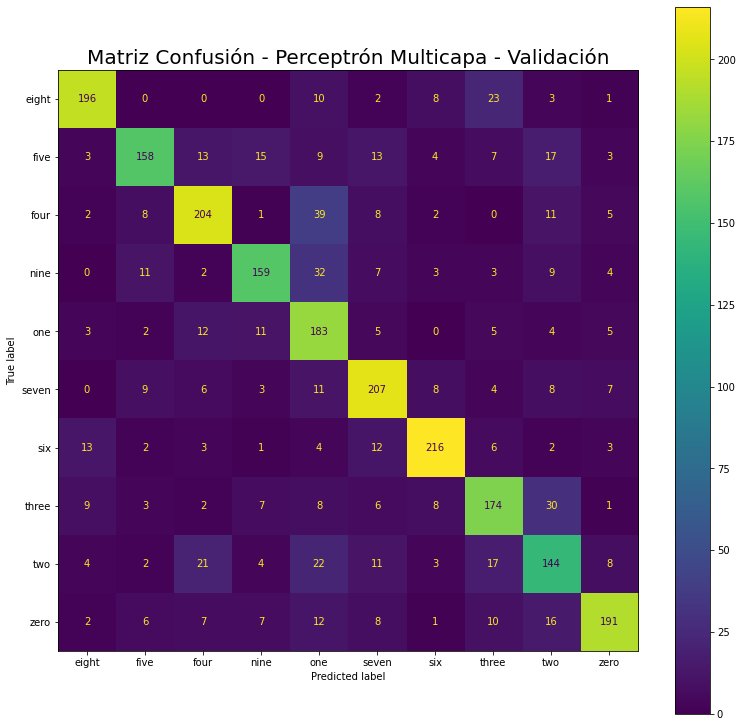

Accuracy training : 0.853
Accuracy Validation: 0.735
Best Multilayer Perceptron Score 0.758 with params {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.05}


In [26]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_confusion_matrix(clf_mlp_, x_validation, y_validation, ax = ax,values_format='.0f')
plt.title("Matriz Confusión - Perceptrón Multicapa - Validación", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_mlp_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_mlp_.score(x_validation, y_validation)))
print("Best Multilayer Perceptron Score {0:.3f} with params {1}".format(clf_mlp_.best_score_, clf_mlp_.best_params_))

In [27]:
# medidas de performance 
y_validation_pred= clf_mlp_.predict(x_validation)

print(classification_report(y_validation,y_validation_pred))
clf_mlp_score=pd.DataFrame.from_dict(classification_report(y_validation,y_validation_pred,output_dict=True))


              precision    recall  f1-score   support

       eight       0.84      0.81      0.83       243
        five       0.79      0.65      0.71       242
        four       0.76      0.73      0.74       280
        nine       0.76      0.69      0.73       230
         one       0.55      0.80      0.65       230
       seven       0.74      0.79      0.76       263
         six       0.85      0.82      0.84       262
       three       0.70      0.70      0.70       248
         two       0.59      0.61      0.60       236
        zero       0.84      0.73      0.78       260

    accuracy                           0.73      2494
   macro avg       0.74      0.73      0.73      2494
weighted avg       0.75      0.73      0.74      2494



# Comparación performance - VALIDACION

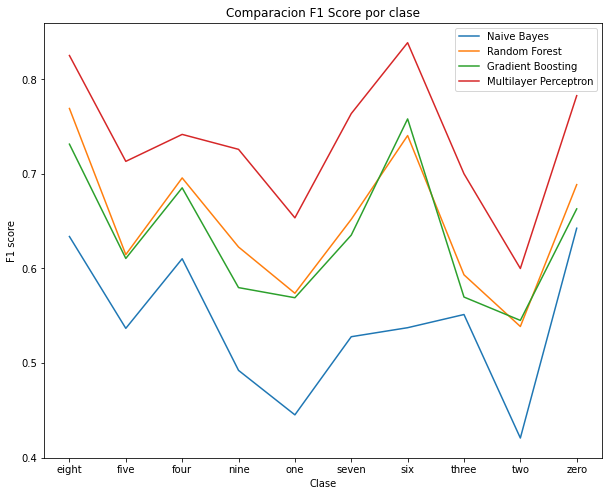

In [28]:
import matplotlib.pyplot as plt
nb_ =clf_nb_score.loc['f1-score'][0:10]
rf_ =clf_rf_score.loc['f1-score'][0:10]
gb_ =clf_gb_score.loc['f1-score'][0:10]
mlp_ =clf_mlp_score.loc['f1-score'][0:10]

fig, ax = plt.subplots(figsize=(10, 8))
line_chart1 = plt.plot(nb_)
line_chart2 = plt.plot(rf_)
line_chart3 = plt.plot(gb_)
line_chart4 = plt.plot(mlp_)
plt.title('Comparacion F1 Score por clase')
plt.ylabel('F1 score')
plt.xlabel('Clase')
plt.legend(['Naive Bayes', 'Random Forest','Gradient Boosting','Multilayer Perceptron'], loc=1)
plt.show()

Text(0.5, 1.0, 'Comparación Modelos: Train&Validation Performance')

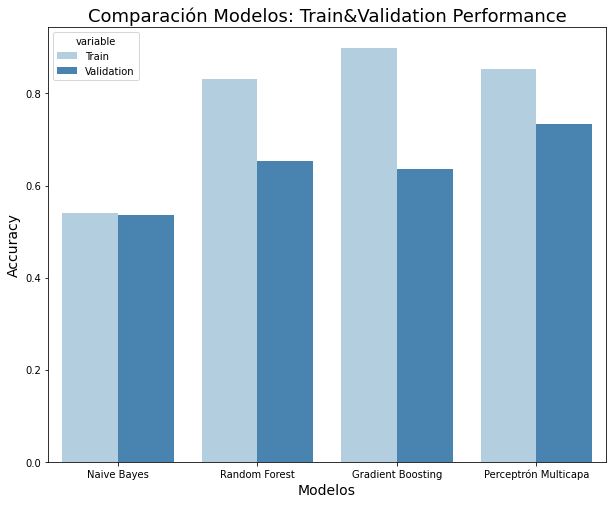

In [29]:
dict_performance_ = {'Modelo': ['Naive Bayes', 'Random Forest', 'Gradient Boosting', 'Perceptrón Multicapa'], 
     'Train': [clf_nb_.score(x_train, y_train), 
               clf_rf_be_.score(x_train, y_train),
               clf_gb_.score(x_train, y_train),
               clf_mlp_.score(x_train, y_train)
               ], 
     'Validation':  [clf_nb_.score(x_validation, y_validation),
               clf_rf_be_.score(x_validation, y_validation),
               clf_gb_.score(x_validation, y_validation),
               clf_mlp_.score(x_validation, y_validation)
               ]}
df_performance_ = pd.DataFrame(data=dict_performance_)

plt.figure(figsize=(10, 8))
sns.barplot(x="Modelo", y="value", hue="variable", data=pd.melt(df_performance_, id_vars=['Modelo']), palette="Blues")
plt.ylabel("Accuracy", size=14)
plt.xlabel("Modelos", size=14)
plt.title("Comparación Modelos: Train&Validation Performance", size=18)

# Testeo de modelos con dataset de Test (held-out), con ruidos gaussianos, ruido ambiente y dataset grabado por nosotros

In [30]:
# Levanto Archivos de Testing con ruidos
github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_numbers_ruido_gya.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features_testing_ = pickle.load(file_)


print(df_features_testing_.shape)

print(df_features.shape)

(5104, 81)
(23666, 81)


In [31]:
# Levanto Archivos de Testing grabado por nosotros
github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_sounds_ours.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features_testing_ours = pickle.load(file_)

print(df_features_testing_ours.shape)


(138, 81)


In [32]:
df_testing = df_features[df_features['group'] == 'testing']
df_testing_amb = df_features_testing_[df_features_testing_['group'] == 'testing_ruido_amb']
df_testing_gaus = df_features_testing_[df_features_testing_['group'] == 'testing_ruido_gaus']
df_testing_ours = df_features_testing_ours[df_features_testing_ours['group'] == 'test_ours_sounds']

del df_testing['group']
del df_testing['file']
del df_testing_amb['group']
del df_testing_amb['file']
del df_testing_gaus['group']
del df_testing_gaus['file']
del df_testing_ours['group']
del df_testing_ours['file']

features = df_testing.loc[:, df_testing.columns != 'target'].columns
target = 'target'

x_testing, y_testing = df_testing[features].values, df_testing[target].values
x_testing_amb, y_testing_amb = df_testing_amb[features].values, df_testing_amb[target].values
x_testing_gaus, y_testing_gaus = df_testing_gaus[features].values, df_testing_gaus[target].values
x_testing_ours, y_testing_ours = df_testing_ours[features].values, df_testing_ours[target].values


Comienzo por probar los mejores modelos con performance en Testing para que corran en Test sin y con ruido respectivamente...

Los mejores modelos..

clfnb.score(x_train, y_train), clf_rfbe.score(x_train, y_train), clfgb.score(x_train, y_train), clfmlp.score(x_train, y_train)

In [33]:
modelos_list_ = [('Naive Bayes', clf_nb_), 
                 ('Random Forest', clf_rf_be_), 
                 ('Gradient Boosting', clf_gb_be_), 
                 ('Multilayer Perceptron', clf_mlp_be_)]

testing_list_ = [(x_testing, y_testing, 'Test original'), 
                    (x_testing_amb, y_testing_amb, 'Test c/ruido Gaussiano'), 
                    (x_testing_gaus, y_testing_gaus, 'Test c/ruido Ambiental'), 
                    (x_testing_ours, y_testing_ours, 'Test audios nuestros')]
                    
acc_test = {} # Voy a armar un diccionario
score_test = {}
for modelo in modelos_list_:
  acc_test[modelo[0]] = {}
  score_test[modelo[0]] = {}
  for test_set in testing_list_:
    acc_test[modelo[0]][test_set[2]] = round(modelo[1].score(test_set[0], test_set[1]) * 100, 2)
    test_pred = modelo[1].predict(test_set[0])
    score_test[modelo[0]][test_set[2]] =pd.DataFrame.from_dict(classification_report(test_set[1],test_pred,output_dict=True))

model_test = {}
for test_set in testing_list_:
  model_test[test_set[2]] = {}
  for modelo in modelos_list_:
    test_pred = modelo[1].predict(test_set[0])
    model_test[test_set[2]][modelo[0]] =pd.DataFrame.from_dict(classification_report(test_set[1],test_pred,output_dict=True))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
df_acc_test_ = pd.DataFrame.from_dict(acc_test)
df_acc_test_

,Naive Bayes,Random Forest,Gradient Boosting,Multilayer Perceptron
Test original,52.820,63.210,61.520,72.730
Test c/ruido Gaussiano,44.040,54.550,52.040,60.270
Test c/ruido Ambiental,45.260,55.170,53.210,63.400
Test audios nuestros,44.930,56.520,54.350,64.490


In [35]:
score_test

{'Gradient Boosting': {'Test audios nuestros':            eight   five   four   nine  ...   zero  accuracy  macro avg  weighted avg
  precision  0.100  0.786  0.750  0.538  ...  0.600     0.543      0.545         0.538
  recall     0.059  0.786  0.923  0.538  ...  0.692     0.543      0.541         0.543
  f1-score   0.074  0.786  0.828  0.538  ...  0.643     0.543      0.527         0.526
  support   17.000 14.000 13.000 13.000  ... 13.000     0.543    138.000       138.000
  
  [4 rows x 13 columns],
  'Test c/ruido Ambiental':             eight    five    four  ...  accuracy  macro avg  weighted avg
  precision   0.677   0.598   0.637  ...     0.532      0.545         0.545
  recall      0.611   0.531   0.534  ...     0.532      0.533         0.532
  f1-score    0.642   0.562   0.581  ...     0.532      0.534         0.533
  support   257.000 271.000 253.000  ...     0.532   2552.000      2552.000
  
  [4 rows x 13 columns],
  'Test c/ruido Gaussiano':             eight    five    f

In [36]:
model_test

{'Test audios nuestros': {'Gradient Boosting':            eight   five   four   nine  ...   zero  accuracy  macro avg  weighted avg
  precision  0.100  0.786  0.750  0.538  ...  0.600     0.543      0.545         0.538
  recall     0.059  0.786  0.923  0.538  ...  0.692     0.543      0.541         0.543
  f1-score   0.074  0.786  0.828  0.538  ...  0.643     0.543      0.527         0.526
  support   17.000 14.000 13.000 13.000  ... 13.000     0.543    138.000       138.000
  
  [4 rows x 13 columns],
  'Multilayer Perceptron':            eight   five   four   nine  ...   zero  accuracy  macro avg  weighted avg
  precision  1.000  1.000  0.750  0.900  ...  0.600     0.645      0.721         0.738
  recall     0.118  1.000  0.923  0.692  ...  0.231     0.645      0.634         0.645
  f1-score   0.211  1.000  0.828  0.783  ...  0.333     0.645      0.609         0.618
  support   17.000 14.000 13.000 13.000  ... 13.000     0.645    138.000       138.000
  
  [4 rows x 13 columns],
  'N

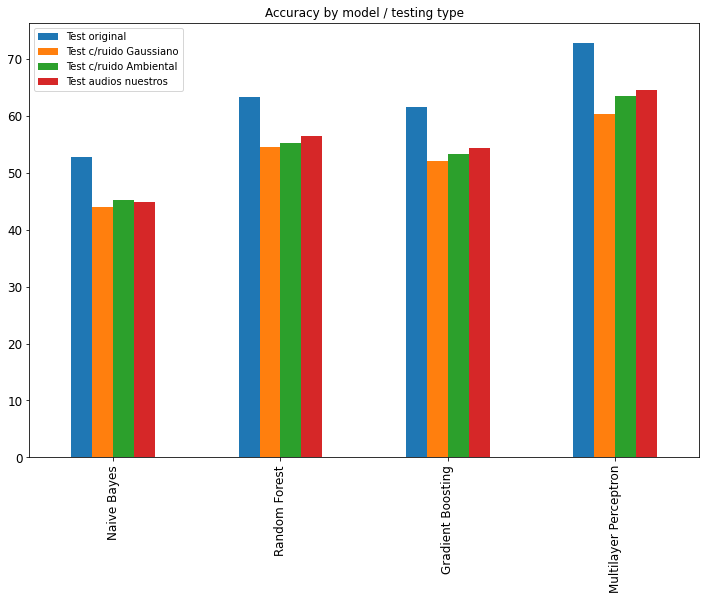

In [37]:
df_acc_test_.T.plot(kind='bar', legend=True, figsize=(12,8), title='Accuracy by model / testing type', fontsize=12)


## Matriz de Confusión para Ruidos

In [38]:
# Voy a hacer uso de una Matriz de Confusión "interactiva"
! pip -q install pygal

     |████████████████████████████████| 133kB 3.5MB/s 


In [39]:
import pygal
from IPython.display import display, HTML
from pygal.style import RedBlueStyle

In [40]:
render_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = render_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))

    
def plot_cm(y_true, y_pred):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    dot_chart = pygal.Dot(interpolate='cubic', style=RedBlueStyle)
    dot_chart.force_uri_protocol = 'http'
    dot_chart.title = 'Matriz de Confusión'
    dot_chart.x_labels = labels
    dot_chart.x_title = "Predicho"
    dot_chart.y_title = "Real"
    for i in range(len(labels)):
        dot_chart.add(labels[i], cm[i,:])
    galplot(dot_chart)
    
plot_cm(y_testing, clf_mlp_be_.predict(x_testing)) # hacerlo con el conjunto de test



###Comparacion de performance - Tipos de testing por modelo

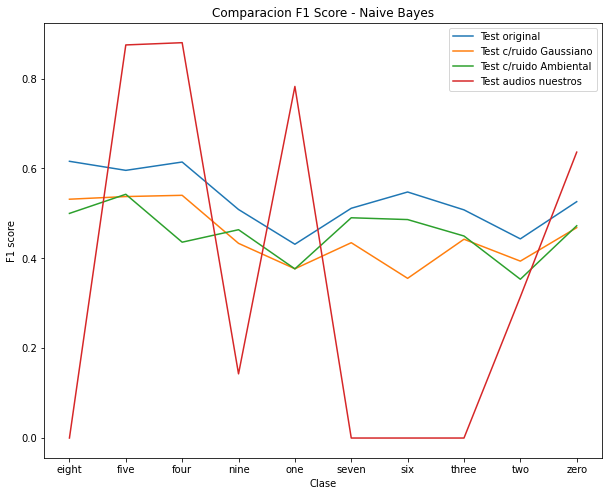

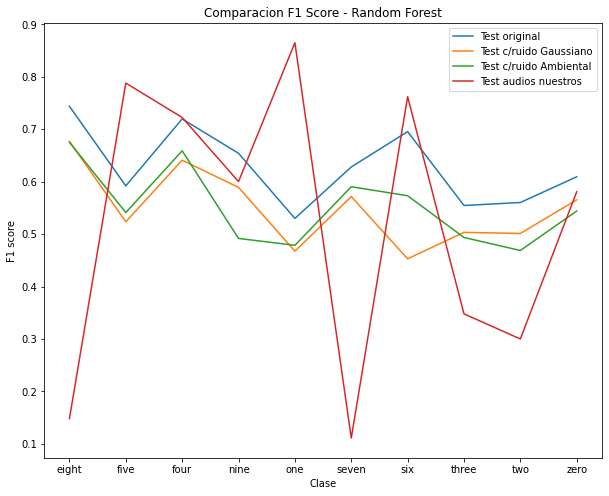

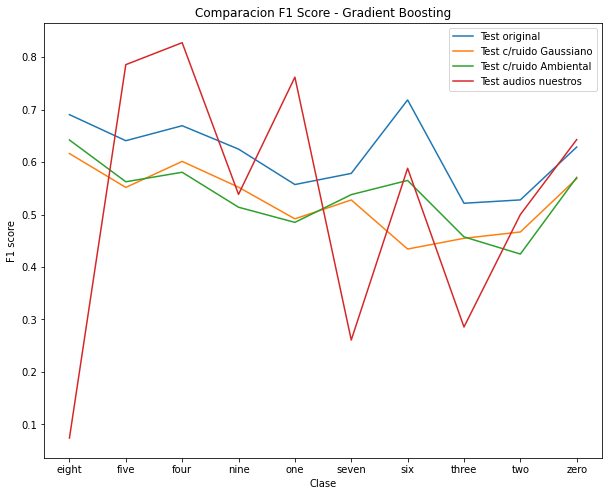

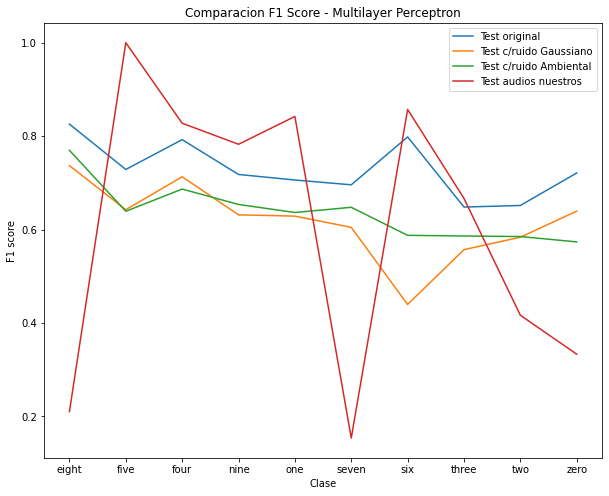

In [41]:
import matplotlib.pyplot as plt


for modelo, test_scores in score_test.items():
  fig, ax = plt.subplots(figsize=(10, 8))
  legend = []
  for test_type, score in test_scores.items():
    plt.plot(score.loc['f1-score'][0:10])
    legend.append(test_type)
  plt.title('Comparacion F1 Score - ' + modelo)
  plt.ylabel('F1 score')
  plt.xlabel('Clase')
  plt.legend(legend, loc=1)
  plt.show()

###Comparacion de performance - Tipos de modelos por testing

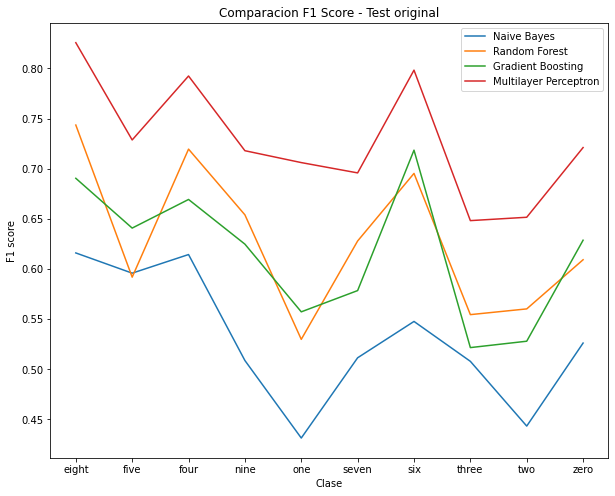

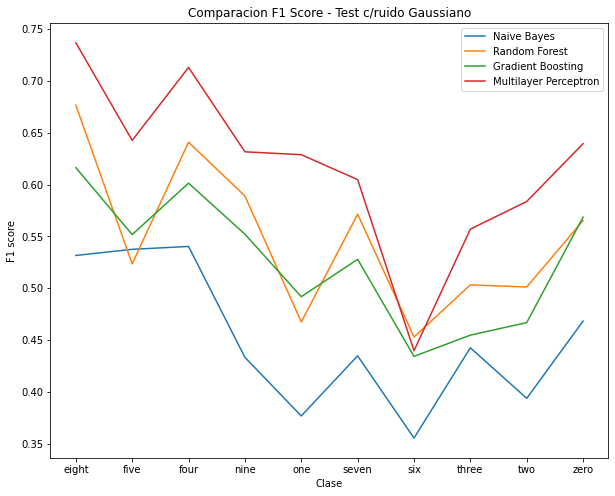

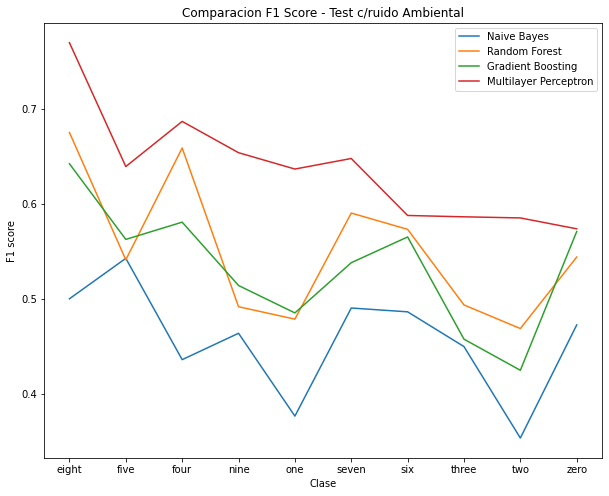

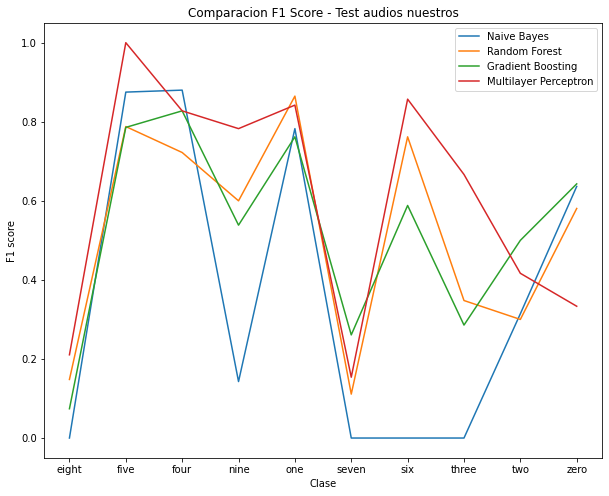

In [42]:
import matplotlib.pyplot as plt



for modelo, test_scores in model_test.items():
  fig, ax = plt.subplots(figsize=(10, 8))
  legend = []
  for test_type, score in test_scores.items():
    plt.plot(score.loc['f1-score'][0:10])
    legend.append(test_type)
  plt.title('Comparacion F1 Score - ' + modelo)
  plt.ylabel('F1 score')
  plt.xlabel('Clase')
  plt.legend(legend, loc=1)
  plt.show()